### Data Dictionary

In this lab, you will use machine learning to train a predictive model that predicts daily lemonade sales based on variables such as the weather and the number of flyers distributed.

### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
from xgboost import to_graphviz, plot_importance

%matplotlib inline
sns.set_style('dark')
sns.set(font_scale=1.5)

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report, mean_absolute_error, mean_squared_error,r2_score
from sklearn.metrics import plot_confusion_matrix, plot_precision_recall_curve, plot_roc_curve, accuracy_score
from sklearn.metrics import auc, f1_score, precision_score, recall_score, roc_auc_score

import feature_engine.missing_data_imputers as mdi
from feature_engine.outlier_removers import Winsorizer

from tpot import TPOTClassifier, TPOTRegressor
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

import warnings
warnings.filterwarnings('ignore')

import pickle
from pickle import dump, load

pd.options.display.max_columns= None
#pd.options.display.max_rows = None

Using TensorFlow backend.
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

### Data Exploration

In [2]:
df = pd.read_csv("Lemonade.csv", parse_dates=['Date'],dayfirst=True)

In [3]:
df

,Date,Day,Temperature,Rainfall,Flyers,Price,Sales
0,2017-01-01,Sunday,27.0,2.00,15,0.3,10
1,2017-01-02,Monday,28.9,1.33,15,0.3,13
2,2017-01-03,Tuesday,34.5,1.33,27,0.3,15
3,2017-01-04,Wednesday,44.1,1.05,28,0.3,17
4,2017-01-05,Thursday,42.4,1.00,33,0.3,18
...,...,...,...,...,...,...,...
362,2017-12-29,Friday,39.5,1.25,17,0.3,15
363,2017-12-30,Saturday,30.9,1.43,22,0.3,13
364,2017-12-31,Sunday,15.1,2.50,9,0.3,7
365,2018-01-01,Saturday,37.6,0.80,23,0.3,-999


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 367 entries, 0 to 366
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         367 non-null    datetime64[ns]
 1   Day          367 non-null    object        
 2   Temperature  367 non-null    float64       
 3   Rainfall     367 non-null    float64       
 4   Flyers       367 non-null    int64         
 5   Price        367 non-null    float64       
 6   Sales        367 non-null    int64         
dtypes: datetime64[ns](1), float64(3), int64(2), object(1)
memory usage: 20.2+ KB


In [5]:
df.describe(include='all')

,Date,Day,Temperature,Rainfall,Flyers,Price,Sales
count,367,367,367.000000,367.000000,367.000000,367.000000,367.000000
unique,367,7,NaN,NaN,NaN,NaN,NaN
top,2017-10-30 00:00:00,Sunday,NaN,NaN,NaN,NaN,NaN
freq,1,54,NaN,NaN,NaN,NaN,NaN
first,2017-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
last,2018-01-02 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,60.614986,0.827057,40.212534,0.333787,19.741144
std,NaN,NaN,16.228869,0.272614,13.182351,0.075042,75.825843
min,NaN,NaN,15.100000,0.470000,9.000000,0.300000,-999.000000
25%,NaN,NaN,49.650000,0.650000,31.000000,0.300000,20.000000


In [6]:
df.shape

(367, 7)

In [7]:
df.columns

Index(['Date', 'Day', 'Temperature', 'Rainfall', 'Flyers', 'Price', 'Sales'], dtype='object')

### Data Visualization

### Univariate Data Exploration

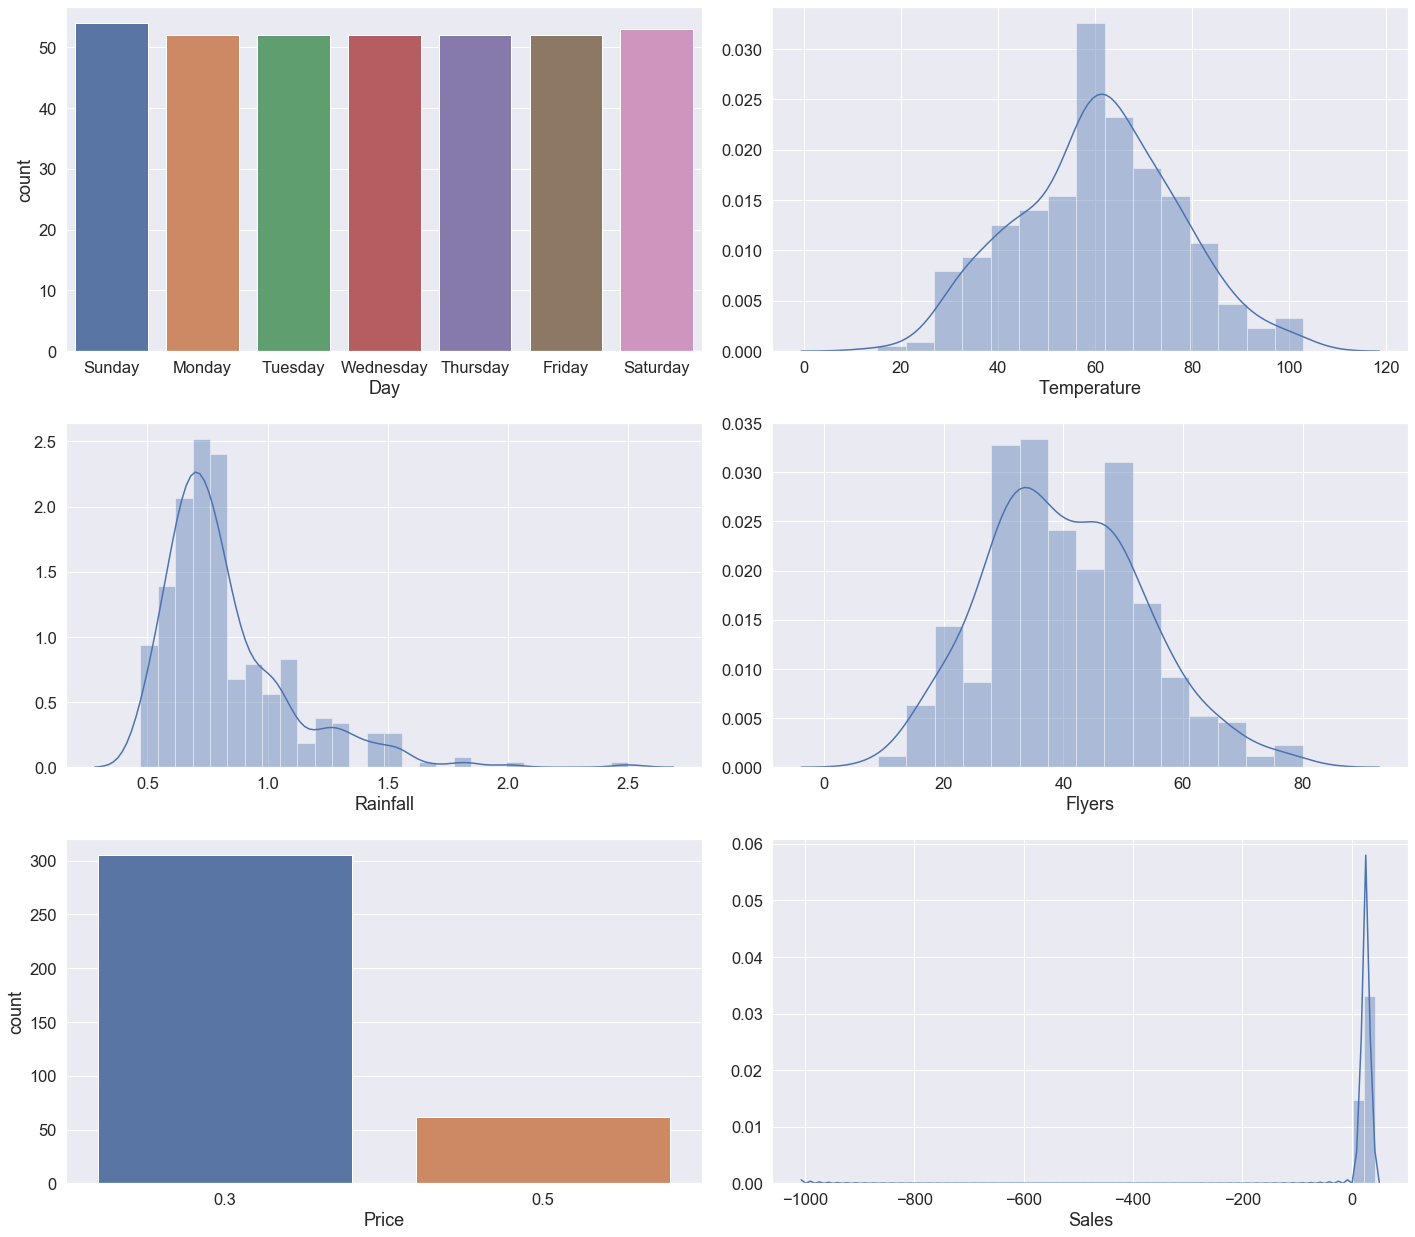

In [8]:
fig = plt.figure(figsize=(20,40))

plt.subplot(7,2,1)
sns.countplot(df.Day)
plt.subplot(7,2,2)
sns.distplot(df.Temperature)
plt.subplot(7,2,3)
sns.distplot(df.Rainfall)
plt.subplot(7,2,4)
sns.distplot(df.Flyers)
plt.subplot(7,2,5)
sns.countplot(df.Price)
plt.subplot(7,2,6)
sns.distplot(df.Sales)
# plt.subplot(7,2,7)
# sns.countplot()
# plt.subplot(7,2,8)
# sns.countplot()
# plt.subplot(7,2,9)
# sns.countplot()
# plt.subplot(7,2,10)
# sns.countplot()
# plt.subplot(7,2,11)
# sns.countplot()
# plt.subplot(7,2,12)
# sns.countplot()
# plt.subplot(7,2,13)
# sns.countplot()
# plt.subplot(7,2,14)
# sns.countplot()

plt.tight_layout()
plt.show()

### Bivariate Data Exploration

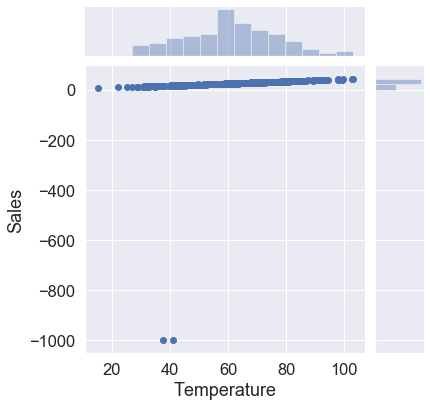

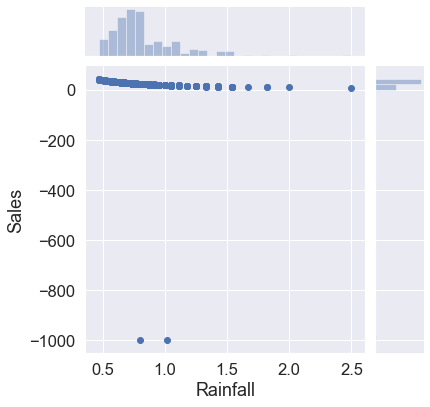

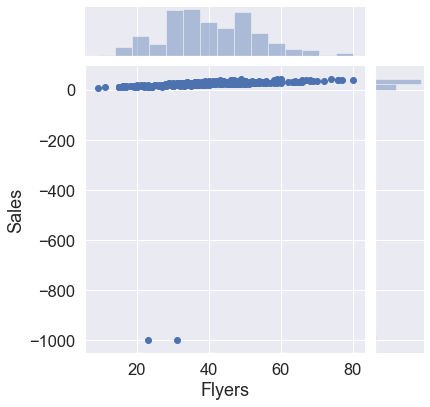

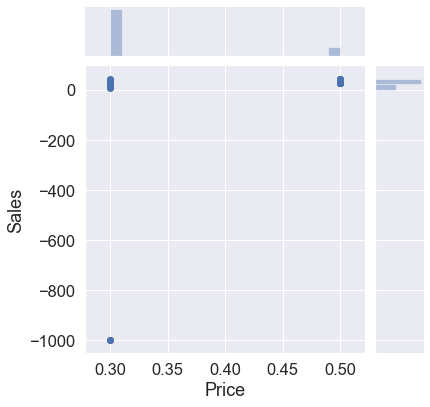

In [9]:
sns.jointplot(x='Temperature', y='Sales',data=df, kind='scatter')

sns.jointplot(x='Rainfall', y='Sales',data=df, kind='scatter')

sns.jointplot(x='Flyers', y='Sales',data=df, kind='scatter')

sns.jointplot(x='Price', y='Sales',data=df, kind='scatter')

plt.show()

In [10]:
df.corr()

,Temperature,Rainfall,Flyers,Price,Sales
Temperature,1.000000,-0.899892,0.798927,0.505271,0.185817
Rainfall,-0.899892,1.000000,-0.745621,-0.384045,-0.104835
Flyers,0.798927,-0.745621,1.000000,0.406469,0.146770
Price,0.505271,-0.384045,0.406469,1.000000,0.079714
Sales,0.185817,-0.104835,0.146770,0.079714,1.000000


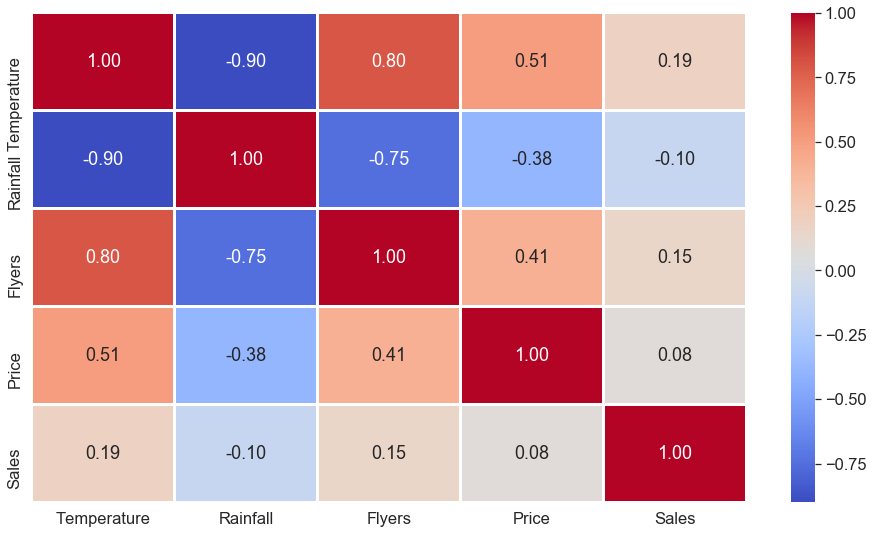

In [11]:
plt.figure(figsize=(16,9))
sns.heatmap(df.corr(),cmap="coolwarm",annot=True,fmt='.2f',linewidths=2)
plt.show()

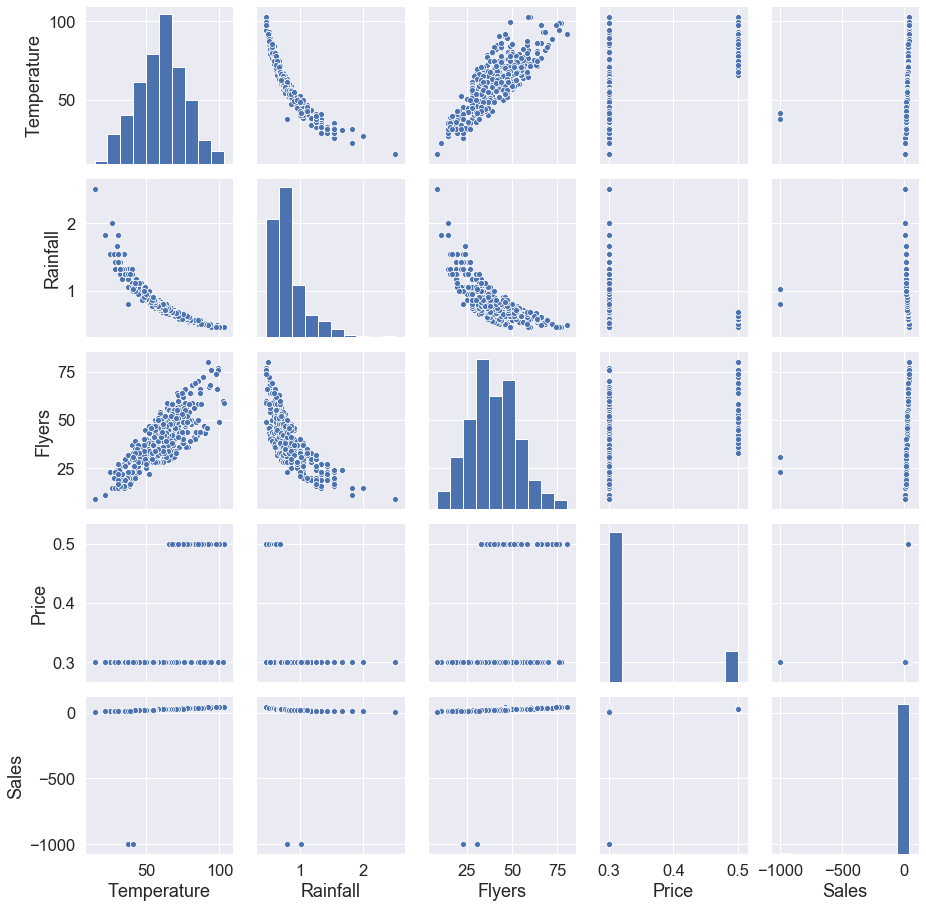

In [12]:
sns.pairplot(df)
plt.show()

### Data Preprocessing

### Treat Missing Values

In [13]:
df.isnull().sum()

Date           0
Day            0
Temperature    0
Rainfall       0
Flyers         0
Price          0
Sales          0
dtype: int64

### Treat Duplicate Values

In [14]:
df.duplicated(keep='first').sum()

0

### Treat Outliers

### Treat Data Types

### Drop unwanted features

In [15]:
df.columns

Index(['Date', 'Day', 'Temperature', 'Rainfall', 'Flyers', 'Price', 'Sales'], dtype='object')

In [16]:
df.drop(['Date', 'Day'],axis=1,inplace=True)

In [17]:
df

,Temperature,Rainfall,Flyers,Price,Sales
0,27.0,2.00,15,0.3,10
1,28.9,1.33,15,0.3,13
2,34.5,1.33,27,0.3,15
3,44.1,1.05,28,0.3,17
4,42.4,1.00,33,0.3,18
...,...,...,...,...,...
362,39.5,1.25,17,0.3,15
363,30.9,1.43,22,0.3,13
364,15.1,2.50,9,0.3,7
365,37.6,0.80,23,0.3,-999


### Create and save processed dataset

In [18]:
#df.to_csv("lemontrain.csv",index=False)

### Train Test Split

In [19]:
df = df[0:365]

In [20]:
df.shape

(365, 5)

In [21]:
X = df.iloc[:,0:4]
y = df.iloc[:,4]

In [22]:
X

,Temperature,Rainfall,Flyers,Price
0,27.0,2.00,15,0.3
1,28.9,1.33,15,0.3
2,34.5,1.33,27,0.3
3,44.1,1.05,28,0.3
4,42.4,1.00,33,0.3
...,...,...,...,...
360,42.7,1.00,33,0.3
361,37.8,1.25,32,0.3
362,39.5,1.25,17,0.3
363,30.9,1.43,22,0.3


In [23]:
y

0      10
1      13
2      15
3      17
4      18
       ..
360    19
361    16
362    15
363    13
364     7
Name: Sales, Length: 365, dtype: int64

### Standardise Test Data

In [ ]:
scaler = StandardScaler()

In [ ]:
X_scaled = scaler.fit_transform(X)

In [ ]:
X_scaled

In [ ]:
X_scaled = pd.DataFrame(X_scaled,columns=X.columns)

In [ ]:
X_scaled

In [ ]:
testdata = X_scaled[365:]

In [ ]:
testdata

In [ ]:
#testdata.to_csv('testreg.csv',index=False)

*-----------------------------------------------------------------------------------------------------------*

In [24]:
X.values, y.values

(array([[27.  ,  2.  , 15.  ,  0.3 ],
        [28.9 ,  1.33, 15.  ,  0.3 ],
        [34.5 ,  1.33, 27.  ,  0.3 ],
        ...,
        [39.5 ,  1.25, 17.  ,  0.3 ],
        [30.9 ,  1.43, 22.  ,  0.3 ],
        [15.1 ,  2.5 ,  9.  ,  0.3 ]]),
 array([10, 13, 15, 17, 18, 11, 13, 15, 17, 18, 12, 14, 15, 17, 18, 12, 14,
        16, 17, 12, 14, 16, 17, 12, 14, 16, 17, 13, 14, 17, 18, 18, 20, 21,
        22, 18, 20, 21, 22, 19, 20, 21, 22, 18, 19, 20, 21, 18, 19, 20, 21,
        18, 19, 20, 21, 18, 19, 20, 22, 23, 24, 24, 25, 23, 24, 24, 25, 23,
        24, 24, 25, 23, 23, 24, 24, 25, 23, 23, 24, 24, 25, 23, 23, 24, 25,
        25, 23, 24, 24, 25, 25, 26, 26, 27, 28, 25, 26, 26, 27, 25, 26, 27,
        27, 25, 26, 27, 27, 25, 26, 27, 27, 25, 26, 27, 27, 25, 25, 26, 27,
        27, 29, 29, 30, 31, 28, 29, 29, 30, 31, 28, 29, 29, 30, 31, 28, 29,
        29, 30, 31, 28, 29, 30, 31, 28, 29, 30, 31, 29, 29, 30, 31, 31, 33,
        35, 38, 32, 34, 36, 39, 32, 35, 36, 40, 32, 35, 36, 41, 31, 32, 3

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.2, random_state=0)

In [26]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((292, 4), (73, 4), (292,), (73,))

### Feature Scaling

In [27]:
X_train

array([[58.5 ,  0.8 , 50.  ,  0.3 ],
       [55.9 ,  0.87, 32.  ,  0.3 ],
       [72.  ,  0.63, 51.  ,  0.5 ],
       ...,
       [58.8 ,  0.74, 32.  ,  0.3 ],
       [40.4 ,  1.  , 29.  ,  0.3 ],
       [72.3 ,  0.65, 36.  ,  0.3 ]])

In [28]:
scaler = StandardScaler()

In [29]:
X_train_scaled = scaler.fit_transform(X_train)

In [30]:
X_test_scaled = scaler.transform(X_test)

In [31]:
X_train_scaled

array([[-0.13159594, -0.1141883 ,  0.7016875 , -0.44905021],
       [-0.28702163,  0.13570558, -0.62257444, -0.44905021],
       [ 0.67542208, -0.72107343,  0.77525761,  2.22692247],
       ...,
       [-0.1136622 , -0.32838305, -0.62257444, -0.44905021],
       [-1.21359787,  0.59979421, -0.84328477, -0.44905021],
       [ 0.69335582, -0.64967518, -0.32829401, -0.44905021]])

In [32]:
X_test_scaled

array([[ 0.20316709, -0.43548043,  1.14310815, -0.44905021],
       [-0.05388309, -0.43548043,  0.92239783, -0.44905021],
       [-0.52016017,  0.27850208, -0.54900433, -0.44905021],
       [-1.11197338,  0.77828984, -1.35827552, -0.44905021],
       [-0.14952967, -0.22128567, -0.54900433, -0.44905021],
       [-1.7037866 ,  2.1348566 , -1.06399509, -0.44905021],
       [-0.19137505, -0.1141883 , -0.54900433, -0.44905021],
       [-0.95654769,  0.42129858, -0.2547239 , -0.44905021],
       [ 1.01018511, -0.72107343,  0.6281174 ,  2.22692247],
       [-1.66194122,  2.52754698, -1.57898585, -0.44905021],
       [ 0.35859279, -0.64967518,  1.14310815, -0.44905021],
       [ 0.61564297, -0.57827693, -0.47543423, -0.44905021],
       [-0.05388309, -0.43548043,  0.11312664, -0.44905021],
       [-0.07181682, -0.32838305, -0.91685487, -0.44905021],
       [ 0.12545425, -0.43548043,  0.84882772, -0.44905021],
       [ 1.04605258, -0.86386993,  0.84882772,  2.22692247],
       [-0.19137505, -0.

### Model Training

### Using XGBoost (Scikit-Learn)

In [33]:
xgbmodel = XGBRegressor(random_state=0, n_estimators=200, objective='reg:squarederror')

In [34]:
xgbmodel.fit(X_train_scaled,y_train,eval_set=[(X_test_scaled,y_test)],eval_metric='rmse',early_stopping_rounds=10)

[0]	validation_0-rmse:23.1195
Will train until validation_0-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:20.834
[2]	validation_0-rmse:18.7449
[3]	validation_0-rmse:16.8906
[4]	validation_0-rmse:15.2307
[5]	validation_0-rmse:13.7551
[6]	validation_0-rmse:12.3944
[7]	validation_0-rmse:11.1966
[8]	validation_0-rmse:10.0993
[9]	validation_0-rmse:9.12155
[10]	validation_0-rmse:8.24359
[11]	validation_0-rmse:7.44928
[12]	validation_0-rmse:6.73483
[13]	validation_0-rmse:6.07771
[14]	validation_0-rmse:5.48799
[15]	validation_0-rmse:4.95479
[16]	validation_0-rmse:4.47254
[17]	validation_0-rmse:4.04736
[18]	validation_0-rmse:3.66697
[19]	validation_0-rmse:3.31761
[20]	validation_0-rmse:3.00595
[21]	validation_0-rmse:2.72751
[22]	validation_0-rmse:2.4766
[23]	validation_0-rmse:2.25487
[24]	validation_0-rmse:2.05937
[25]	validation_0-rmse:1.88204
[26]	validation_0-rmse:1.72778
[27]	validation_0-rmse:1.59533
[28]	validation_0-rmse:1.47288
[29]	validation_0-rmse:1.36694
[30]	validation_0

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=200,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [35]:
y_pred = xgbmodel.predict(X_test_scaled)

In [36]:
y_pred

array([27.089119 , 26.79179  , 21.803223 , 17.21898  , 24.935436 ,
       13.388537 , 24.501    , 19.67498  , 31.252098 , 12.889828 ,
       29.208559 , 29.553455 , 26.476679 , 25.07194  , 26.959618 ,
       32.814617 , 24.897831 , 26.281742 , 29.74876  , 28.819138 ,
       30.905756 , 34.55406  , 23.361174 , 23.334513 , 24.897831 ,
       26.481047 , 23.634094 , 20.011023 , 27.27899  , 34.770657 ,
       27.703266 , 26.826675 , 12.634539 , 21.932539 , 20.916626 ,
       11.6688595, 24.501    , 29.444817 , 25.84017  , 24.875408 ,
       32.20243  , 23.913622 , 31.031898 , 26.970903 , 15.363546 ,
       22.275993 , 31.032755 , 30.966728 , 30.744844 , 25.07265  ,
       32.565395 , 31.216135 , 32.475006 , 33.94807  , 25.567797 ,
       18.222084 , 19.596106 , 28.705833 , 24.874569 , 22.649893 ,
       22.083681 , 27.890814 , 16.458807 , 25.350313 , 22.691208 ,
       12.825709 , 18.520964 , 30.419628 , 29.539812 , 31.968122 ,
       23.697718 , 35.35104  , 26.970903 ], dtype=float32)

### Model Evaluation

In [37]:
mse = mean_squared_error(y_test,y_pred)
mse

0.5043607109588539

In [38]:
rmse = np.sqrt(mse)
rmse

0.7101835755344205

In [39]:
r2score = r2_score(y_test,y_pred)
r2score

0.9855612833406766

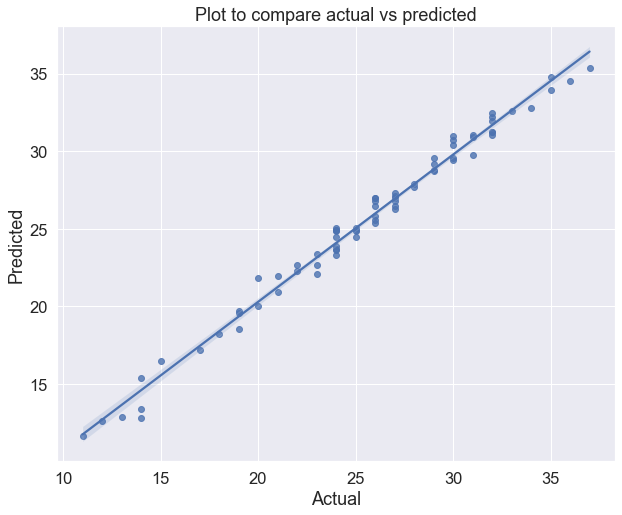

In [40]:
fig, ax = plt.subplots(figsize=(10,8))
sns.regplot(x=y_test, y=y_pred, ax=ax)
plt.title("Plot to compare actual vs predicted")
plt.ylabel("Predicted")
plt.xlabel("Actual")
plt.show()

### Available importance_types = [‘weight’, ‘gain’, ‘cover’, ‘total_gain’, ‘total_cover’]

In [41]:
X.columns

Index(['Temperature', 'Rainfall', 'Flyers', 'Price'], dtype='object')

In [42]:
xgbmodel.get_booster().feature_names

['f0', 'f1', 'f2', 'f3']

In [43]:
xgbmodel.get_booster().feature_names = ['Temperature', 'Rainfall', 'Flyers', 'Price']

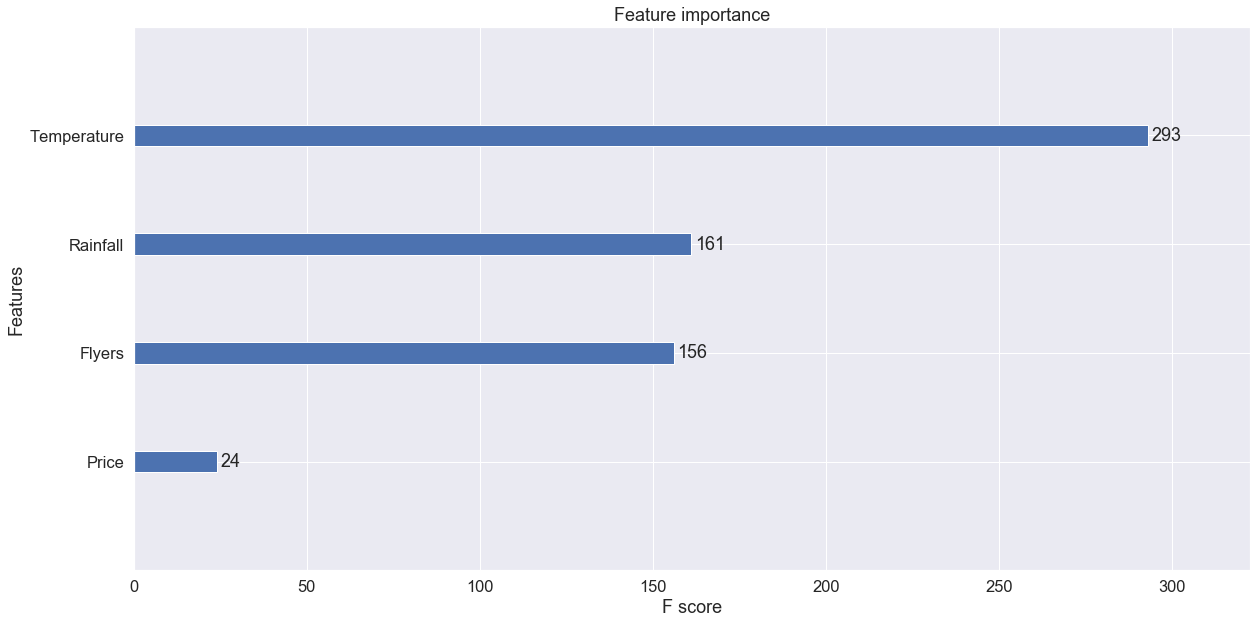

In [44]:
fig, ax = plt.subplots(figsize=(20,10))
xgb.plot_importance(xgbmodel.get_booster(),ax=ax)
plt.show()

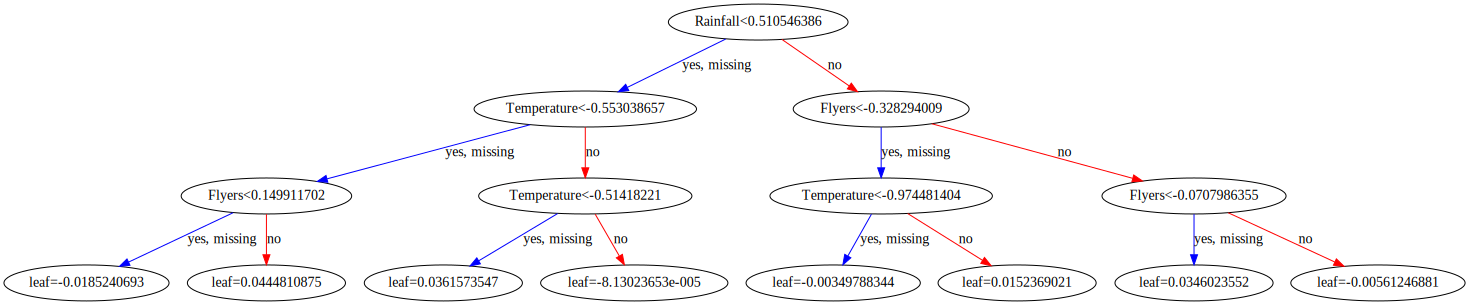

In [45]:
xgb.to_graphviz(xgbmodel,num_trees=100)

### Cross-Validation

In [46]:
cv = cross_val_score(xgbmodel,X_train_scaled,y_train,cv=5,verbose=1,scoring='r2')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.3s finished


In [47]:
cv.mean()

0.9878599307028759

### Save the Model

In [48]:
filename = 'modellemon.sav'
dump(xgbmodel,open(filename,'wb'))

### Model Prediction

In [50]:
testdata = pd.read_csv('testreg.csv')

In [51]:
testdata

,Temperature,Rainfall,Flyers,Price
0,-1.420087,-0.099386,-1.307508,-0.450864
1,-1.197957,0.708716,-0.699808,-0.450864


In [52]:
answer = xgbmodel.predict(testdata)

In [53]:
answer

array([20.541985, 17.299335], dtype=float32)

### Model Tuning

### Using RandomSearchCV

In [54]:
model = XGBRegressor(random_state=0, n_estimators=200, objective='reg:squarederror')

In [55]:
parameters = {'max_depth': np.arange(3,10,1),
              'learning rate': np.arange(0.05,0.3,0.03),
              'n_estimators':np.arange(100,1000,100),
              'min_child_weight': np.arange(1,4,1),
              'gamma':np.arange(0,50,2),
              'subsample':np.arange(0.5,0.9,0.1),
              'colsample_bytree':np.arange(0.5,0.9,0.1)
             }

In [56]:
randm = RandomizedSearchCV(estimator=model, param_distributions = parameters, cv = 5, n_iter = 50, 
                           n_jobs=-1, scoring='r2')

In [57]:
randm.fit(X_train_scaled, y_train)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=None, n_estimators=200,
                                          n_jobs=1, nthread=None,
                                          objective='reg:squarederror',
                                          random_state=0, reg_...
       34, 36, 38, 40, 42, 44, 46, 48]),
                                        'learning rate': array([0.05, 0.08, 0.11, 0.14, 0.17, 0.2 , 0.23, 0.26, 0.29]),
                           

In [58]:
randm.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7999999999999999, gamma=6,
             importance_type='gain', learning rate=0.08, learning_rate=0.1,
             max_delta_step=0, max_depth=7, min_child_weight=1, missing=None,
             n_estimators=500, n_jobs=1, nthread=None,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
             subsample=0.7999999999999999, verbosity=1)

In [59]:
randm.best_score_

0.9878562139689244

In [60]:
randm.best_params_

{'subsample': 0.7999999999999999,
 'n_estimators': 500,
 'min_child_weight': 1,
 'max_depth': 7,
 'learning rate': 0.08,
 'gamma': 6,
 'colsample_bytree': 0.7999999999999999}